## Micrograd Lecture
#### https://youtu.be/VMj-3S1tku0?si=L9uoak1hkI_eeD3T

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def func1(x):
    return 2*x**3 + 5*x + 3

In [3]:
x = np.arange(-5, 5, 0.25)
y = func1(x)

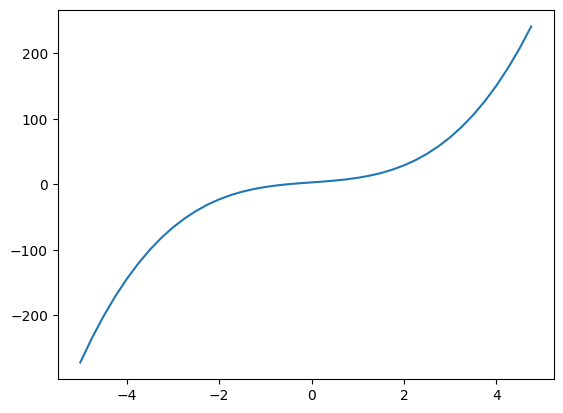

In [4]:
plt.plot(x,y)

#### Finding the slope at -3 aka the derivative of this function at -3

$$
f'(x) = \frac{f(x+h)-f(x)}{h}
$$

In [5]:
h = 0.0000001
(func1(-3+h)-func1(-3))/h # +ve

58.99999820258017

In [6]:
(func1(0+h)-func1(0))/h # +ve

5.00000000069889

#### equation with multiple variables

In [7]:
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print("d1:", d1)
print("d2:", d2)
print("slope:", (d2-d1)/h)

d1: 4.0
d2: 3.9999997
slope: -2.9999999995311555


#### Creating the Value class

In [8]:
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __add__(self, other):
        return Value(self.data + other.data, (self, other), "+")

    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), "*")
        
    def __repr__(self):
        return f"Value(data={self.data})"

In [10]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a*b
e.label = "e"
d = e + c
d.label = "d"
f = Value(-2.0, label="f")
L = d*f; L.label="L"

In [27]:
# Check why dL/db = 0??? It shouldnt be
def comp():
    
    h = 0.0001
    
    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a*b
    d = e + c
    f = Value(-2.0, label="f")
    L = d*f
    L1 = L.data

    a = Value(2.0, label="a")
    # a.data += h
    b.data += h
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a*b
    d = e + c
    f = Value(-2.0, label="f")
    L = d*f
    L2 = L.data

    print((L2 - L1)/h)

comp()

0.0


In [12]:
# Visualization function
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

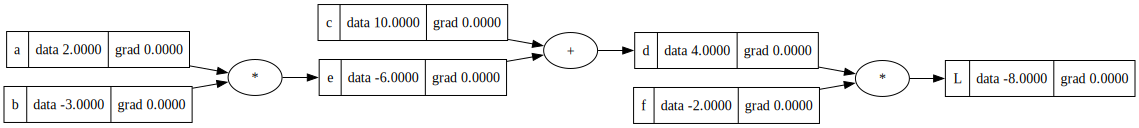

In [16]:
draw_dot(L)